In [1]:
import numpy as np
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap

# SimPEG, discretize
import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg import Report, maps
from simpeg.utils.solver_utils import get_default_solver

In [2]:
# get default solver -- should be Pardiso or Mumps
Solver = get_default_solver()
Solver

pymatsolver.direct.mumps.Mumps

# define model parameters

 - conductivities are in S/m
 - all lengths are in units of meters

In [3]:
# conductivities
sigma_air = 1e-4  # don't make this too resistive when the casing is very conductive
sigma_back = 1e-2
sigma_fluid = 1  # inside the casing

casing_l = 400
sigma_casing = 5e6
mur_casing = 1  # can include magnetic permeability 

sigma_layer = 1
layer_z = np.r_[-100, -140]

# casing geometry in meters
casing_b = 5e-2  
casing_t = 1e-2 
casing_a = casing_b - casing_t

In [4]:
frequencies = np.r_[10, 100, 1000, 5000]
frequencies

array([  10,  100, 1000, 5000])

In [5]:
source_z = np.linspace(-350, -50, 61)
source_z

array([-350., -345., -340., -335., -330., -325., -320., -315., -310.,
       -305., -300., -295., -290., -285., -280., -275., -270., -265.,
       -260., -255., -250., -245., -240., -235., -230., -225., -220.,
       -215., -210., -205., -200., -195., -190., -185., -180., -175.,
       -170., -165., -160., -155., -150., -145., -140., -135., -130.,
       -125., -120., -115., -110., -105., -100.,  -95.,  -90.,  -85.,
        -80.,  -75.,  -70.,  -65.,  -60.,  -55.,  -50.])

# create a mesh

In [6]:
def pad_for_casing_and_data(
    casing_outer_radius,
    csx1=2.5e-3,
    csx2=25,
    pfx1=1.3,
    pfx2=1.5,
    domain_x=1000,
    npadx=10
):
    """
    This is a helper function to create the horizontal spacing of the mesh. 
    We use fine, uniform cells in the vicinity of the casing, and then pad out 
    to another uniform region, and then pad out to "infinity"
    """
    ncx1 = np.ceil(casing_outer_radius/csx1+2)
    npadx1 = np.floor(np.log(csx2/csx1) / np.log(pfx1))

    # finest uniform region
    hx1a = utils.unpack_widths([(csx1, ncx1)])

    # pad to second uniform region
    hx1b = utils.unpack_widths([(csx1, npadx1, pfx1)])

    # scale padding so it matches cell size properly
    dx1 = np.sum(hx1a)+np.sum(hx1b)
    dx1 = 3 #np.floor(dx1/self.csx2)
    hx1b *= (dx1*csx2 - np.sum(hx1a))/np.sum(hx1b)

    # second uniform chunk of mesh
    ncx2 = np.ceil((domain_x - dx1)/csx2)
    hx2a = utils.unpack_widths([(csx2, ncx2)])

    # pad to infinity
    hx2b = utils.unpack_widths([(csx2, npadx, pfx2)])

    return np.hstack([hx1a, hx1b, hx2a, hx2b])

In [7]:
hx = pad_for_casing_and_data(
   casing_outer_radius = casing_b,
    csx1 = casing_t/4, # finest cells
    csx2 = 25, # cells in second uniform region 
    pfx1 = 1.3, # expansion factors
    pfx2 = 1.5, 
    domain_x = 200, # extent of second uniform region 
    npadx = 9 # number of cells to pad to "infinity" 
)

# z part of the mesh 
pfz = 1.5
npad_z = 22
csz = 0.125
ncore_z = np.abs(casing_l)/csz
hz = discretize.utils.unpack_widths(
    [(csz, npad_z, -pfz), (csz, ncore_z), (csz, npad_z, pfz)]
)

Here, we cerate a cylindrical mesh. This example uses a cylindrically symmetric mesh with a single azimuthal cell that is size 2$\pi$. If you want a 3D cyl mesh, you could replace the second dimension with a discretization in the theta direction, e.g. 

```
n_theta = 12 # number of cells in the azimuthal direction
h_theta = np.ones(n_theta) * 2*np.pi/n_theta
mesh = discretize.CylindricalMesh(
    [hx, h_theta
, hz],  
    origin=np.r_[0, 0, -np.sum(hz[:npad_z + int(ncore_z)])],
)
```

In [8]:
mesh = discretize.CylindricalMesh(
    [hx, np.r_[2*np.pi], hz],  
    origin=np.r_[0, 0, -np.sum(hz[:npad_z + int(ncore_z)])],
)

<Axes: xlabel='x', ylabel='z'>

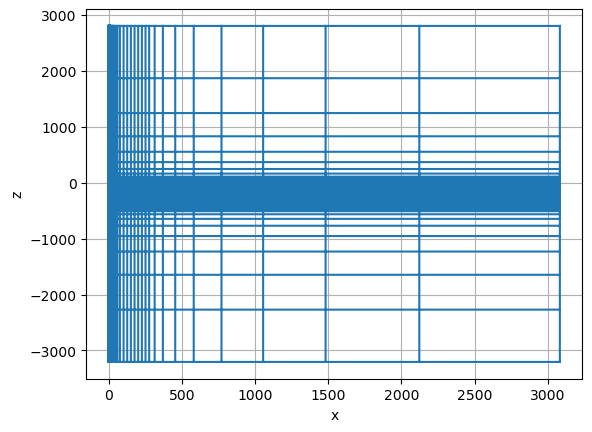

In [9]:
# plot the mesh
fig, ax = plt.subplots(1, 1)
mesh.plot_grid(ax=ax)

make sure there is enough padding in the mesh to extend > 2x the skin depth 

In [10]:
def skin_depth(sigma, mur, freq):
    return np.sqrt(2/(2*np.pi*freq*sigma*mu_0*mur))

In [11]:
skin_depth(sigma_back, 1, frequencies)

array([1591.54943102,  503.29212108,  159.1549431 ,   71.17625435])

# put the model on the mesh 

In [12]:
sigma = np.ones(mesh.n_cells) * sigma_air
sigma[mesh.cell_centers[:, 2] < 0] = sigma_back

inds_layer = (
    (mesh.cell_centers[:, 2] > layer_z.min()) & 
    (mesh.cell_centers[:, 2] < layer_z.max())
)
sigma[inds_layer] = sigma_layer

# casing 
inds_inside = (
    (mesh.cell_centers[:, 0] < casing_a) & 
    (mesh.cell_centers[:, 2] < 0) & 
    (mesh.cell_centers[:, 2] > -casing_l)
)

inds_casing = (
    (mesh.cell_centers[:, 0] > casing_a) & 
    (mesh.cell_centers[:, 0] < casing_b) & 
    (mesh.cell_centers[:, 2] < 0) & 
    (mesh.cell_centers[:, 2] > -casing_l)
)

sigma[inds_inside] = sigma_fluid
sigma[inds_casing] = sigma_casing

# if casing is permeable
mur = np.ones(mesh.n_cells) 
mur[inds_casing] = mur_casing



(-500.0, 10.0)

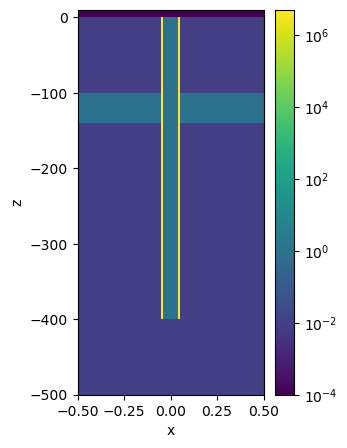

In [13]:
# plot the model 
fig, ax = plt.subplots(1, 1, figsize=(3, 5))

plt.colorbar(
    mesh.plot_image(
        sigma, 
        pcolor_opts={"norm":LogNorm()},
        mirror=True,
        ax=ax
    )[0], ax=ax
)

# ax.plot(np.zeros_like(source_z), source_z, "C3.")

ax.set_xlim(np.r_[-1, 1]*0.5)
ax.set_ylim(np.r_[-500, 10])

# set up the simulation 

First we define the sources and receivers. Each source keeps track of which receivers are "listening" to it. Here, I used B-field receivers (we use MagneticFluxDensity for B), and look at both the real and imaginary component in units of ppm of the primary (comment out the `data_type` to get values as B-fields in T) 

The orientation can be a string or a vector. When using the cylindrically symmetric mesh (e.g. without azimuthal discretization), the source must be oriented in the z-direction, but if you use azimuthal discretization, it can have a different orientation. Note that I have not thoroughly tested rotated sources on the 3D cyl mesh, so it is worth validating against an analytic (e.g. we have an analytic solution for a [dipole in a wholespace in geoana](https://geoana.simpeg.xyz/api/generated/geoana.em.fdem.MagneticDipoleWholeSpace.html#geoana.em.fdem.MagneticDipoleWholeSpace))

In [14]:
source_list = []
rx_offset = 10  # note that you could make this depend on frequency if you put it inside the loop 

for freq in frequencies: 
    for src_z in source_z: 
        src_loc = np.r_[0, 0, src_z]
        rx_loc = np.r_[0, 0, src_z - rx_offset]

        # assemble receiver list containing real and imag b fields
        # note that the orientation can be a string or a vector
        rx_list = [
            fdem.receivers.PointMagneticFluxDensitySecondary(
                locations=rx_loc, 
                orientation="z", 
                component="real",
                data_type="ppm" # measure data as ppm of the primary -- comment out if you want values of B in T
            ), 
            fdem.receivers.PointMagneticFluxDensitySecondary(
                locations=rx_loc, 
                orientation="z", 
                component="imag",
                data_type="ppm"
            )
        ]
        src = fdem.sources.MagDipole(
            location=src_loc, 
            orientation="z", 
            receiver_list=rx_list,
            frequency=freq
        )

        source_list.append(src)

In [15]:
survey = fdem.Survey(source_list) 

simulation = fdem.Simulation3DElectricField(
    mesh=mesh, survey=survey,
    sigmaMap=maps.IdentityMap(mesh), mu=mur*mu_0,
    solver=Solver, forward_only=True
)

# run the simulation 

In [16]:
%%time

dpred = simulation.dpred(sigma)

CPU times: user 26.2 s, sys: 6.83 s, total: 33 s
Wall time: 22.1 s


In [17]:
# rearrange data for easier plotting 
data_sorted = dpred.reshape(len(source_z)*2, len(frequencies), order="F")

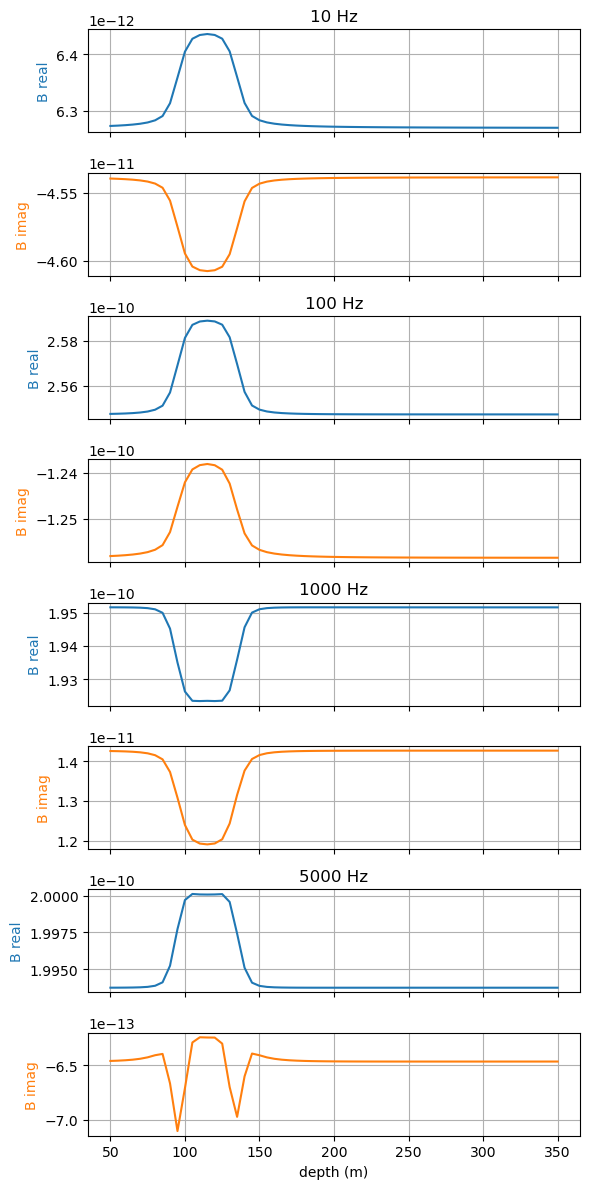

In [22]:
# plot the data 

fig, ax = plt.subplots(len(frequencies)*2, 1, figsize=(6, 12), sharex=True) 

for i, freq in enumerate(frequencies): 
    # B real
    ax[2*i].plot(-source_z, -data_sorted[::2, i], label=freq)
    ax[2*i].set_title(f"{freq} Hz")
    ax[2*i].set_ylabel("B real", color="C0")

    # B imag
    ax[2*i+1].plot(-source_z, data_sorted[1::2, i], "-", color="C1")
    ax[2*i+1].set_ylabel("B imag", color="C1")
    # ax[i].set_title(f"B imag {freq} Hz")

    ax[2*i].grid()
    ax[2*i+1].grid()

ax[-1].set_xlabel("depth (m)")
plt.tight_layout()

In [19]:
Report()

--------------------------------------------------------------------------------
  Date: Tue Sep 30 22:27:31 2025 PDT

                OS : Darwin (macOS 15.6.1)
            CPU(s) : 12
           Machine : arm64
      Architecture : 64bit
               RAM : 64.0 GiB
       Environment : Jupyter
       File system : apfs

  Python 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25)
  [Clang 17.0.6 ]

            simpeg : 0.22.2.dev41+ge21040475
        discretize : 0.11.2
       pymatsolver : 0.3.1
             numpy : 2.2.5
             scipy : 1.15.2
        matplotlib : 3.10.1
            geoana : 0.7.2
            libdlf : 0.3.0
            cython : 3.0.11
              dask : 2025.5.1
           sklearn : 1.7.0
            pandas : 2.2.3
             sympy : 1.13.3
           IPython : 8.29.0
        ipywidgets : 8.1.5
            plotly : 5.24.1
--------------------------------------------------------------------------------